In [21]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from igraph import *
from scipy import stats
from collections import defaultdict
from read_file import read_original_breakpoints,read_file_original

In [22]:
def plot_hist(visualizations,filename):
    n, bins, patches = plt.hist(visualizations, 20, density=True, facecolor='g', alpha=0.75)
    plt.yscale('log')
    plt.savefig(filename)
    plt.cla()

# return indexes
def group_by_num_vis(ys,k1,k2):
    groups = defaultdict(lambda:[])
    deleted = []
    for i,y in ys.items():
        if y > k1:
            if y < k2:
                groups[1].append(i)
            else:
                groups[2].append(i)
        else:
            deleted.append(i)
    return groups,deleted

def deleted_hist():
    deleted_delta_time = []
    for d in deleted:
        x = xs[d]
        delta = x[-1]-x[0]
        deleted_delta_time.append(delta)
    plot_hist(deleted_delta_time,'hist_deleted_articles.png')

In [23]:
def breakpoints_hist():
    idxs = idxs.tolist()

    for k,v in groups.items():
        ys_v = visualizations[v]
        print(k,len(ys_v),min(ys_v),max(ys_v),np.std(ys_v))
        plot_hist(ys_v,'hist_group_'+str(k)+'.png')

        breakpoints_freq = []
        # print(v[:10])
        # print(idxs[:10])
        for i in v:
            try:
                i = idxs.index(i)
                breakpoints_freq.append(len(breakpoints[i]))
            except:
                pass
        plot_hist(breakpoints_freq,'hist_breakpoints_freq_'+str(k)+'.png')

def brusque_changes(slopes,n):
    diffs = []
    idxs = []
    for i,seq_slopes in slopes.items():
        last = seq_slopes[0]
        for slope in seq_slopes[1:]:
            diff = slope - last
            last = slope
            diffs.append(diff)
            idxs.append(i)
    ranking = np.argsort(diffs)
    topN = ranking[-n:].tolist()
    idxs = np.asarray(idxs)
    idxs = idxs[topN]
    return idxs

def calculate_ys(xs,slopes,breakpoints):
    bs = breakpoints.tolist() + [1]
    intercept_x = 0
    intercept_y = 0
    i = 0
    y = 0
    ys = []
    print(bs,slopes)
    for j,x in enumerate(xs):

        if x - bs[i] >= 0.001 and x != 1:
            i += 1

        y = (x-intercept_x)*slopes[i] + intercept_y
        print(y,'=',x,'-',intercept_x,'*',slopes[i],'+',intercept_y)
        ys.append(y)
        
        intercept_x = x
        intercept_y = y

    return ys

def plot(xs,ys,color):
    plt.scatter(xs,ys,color=color)
    
def norm(x):
    return (x-min(x))/(max(x)-min(x))

In [68]:
xs,ys = read_file_original(filename='data/plos_one_data_total.txt')
idxs,slopes,breakpoints,preds = read_file('data/plos_one_total_breakpoints_k4_original1_data_not_norm.txt')
idxs = idxs.tolist()

In [69]:
data = dict()
for i,s,b,p in zip(idxs,slopes,breakpoints,preds):
    data[i] = (s,b,xs[i],ys[i],p)

In [70]:
visualizations = dict()
for k,sample in data.items():
    visualizations[k] = sample[-2][-1]

In [71]:
groups,deleted = group_by_num_vis(visualizations,1000,5000)

In [72]:
for k,v in groups.items():
    print(len(v))

18070
97913


In [73]:
def get_value(data,idx,valid_idxs):
    values = dict()
    for k in valid_idxs:
        values[k] = data[k][idx]
    return values

def get_by_intervals(data,idxs):
    values = defaultdict(lambda:[])
    for k in idxs:
        sample = data[k]
        number_of_intervals = len(sample[0])
        values[number_of_intervals].append(k)
    return values

def get_values_window(xs,ys,x0,delta):
    values = []
    for x,y in zip(xs,ys):
        if x < x0+delta and x > x0-delta:
            values.append(y)
    return np.asarray(values)

def get_values_points(xs,ys,x0,num_points):
    n = len(xs)
    pos = -1
    for i in range(n-1):
        if xs[i] <= x0 and xs[i+1] > x0:
            pos = i
            break
    values = ys[max(0,pos-num_points):min(pos+num_points,n-1)]
    if pos-num_points < 0:
#         print('antes',values,pos,num_points)
        values = np.concatenate([np.zeros(abs(pos-num_points)),values])
#         print(values)
    if pos+num_points > n-1:
#         print('antes',values,pos,num_points)
        values = np.concatenate([values,np.zeros(abs(pos+num_points-n-1))])
#         print(values)
#     if len(values) != 6:
#         print(values,pos,num_points,n)
    return values

In [74]:
def plot_series(groups):
    for k,idxs in groups.items():
        print(k)
        head = 'group'+str(k)
        deltas_std = defaultdict(lambda:[]) 
        groupby_number_intervals = get_by_intervals(data,idxs)
        for number_of_intervals,valid_idxs in groupby_number_intervals.items():
            ranking = brusque_changes(get_value(data,0,valid_idxs),10)
            print(ranking)
            for r in ranking:
                sample = data[r]
    #             x = norm(sample[2][1:])
    #             y = norm(sample[3][1:])
                x = sample[2][1:]
                y = sample[3][1:]

                y_pred = sample[-1]
                bpoints = sample[1]
                slopes = sample[0]

                print(bpoints)
                plot(x,y_pred,'red')
                plot(x,y,'green')
                plt.vlines(bpoints,ymin=min(y),ymax=max(y),color='blue')
                n = len(x)
                for b in bpoints:
                    for i in range(n-1):
                        if x[i] <= b and x[i+1] > b:
                            pos = i
                            break
    #                     print(i,[x[pos-2],b,x[pos+2]])
    #                     print(x)
                    plt.vlines([x[max(0,pos-3)],x[min(pos+3,len(x)-1)]],ymin=min(y),ymax=max(y),color='gray',linestyle='--')
                plt.savefig('imgs_python/preds/'+head+'/original_pred_'+str(number_of_intervals)+'_'+str(r)+'.png')
                plt.show()
                plt.cla()

                plt.vlines(bpoints,ymin=min(y-y_pred),ymax=max(y-y_pred),color='blue')
                n = len(x)
                for b in bpoints:
                    for i in range(n-1):
                        if x[i] <= b and x[i+1] > b:
                            pos = i
                            break
                    plt.vlines([x[max(0,pos-3)],x[min(pos+3,len(x)-1)]],ymin=min(y-y_pred),ymax=max(y-y_pred),color='gray',linestyle='--')
                plt.plot(x,y-y_pred,color='red')
                plt.savefig('imgs_python/preds/'+head+'/original_pred_'+str(number_of_intervals)+'_'+str(r)+'_diff.png')
                plt.show()
                plt.cla()

2
[ 42799  33107 104172  63505 134210  29243   6041  62411  18396 108062]
[2014.84917857 2016.2462474  2016.33757755 2017.08720666]


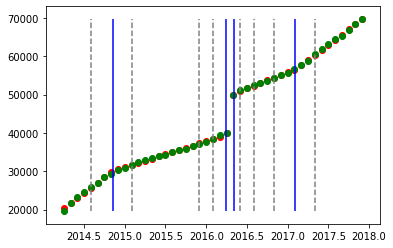

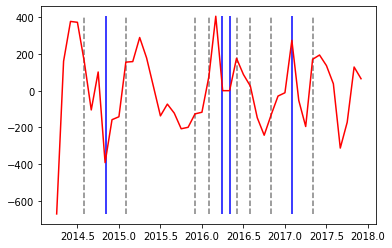

[2013.08307697 2014.66568266 2014.75239167 2016.98660278]


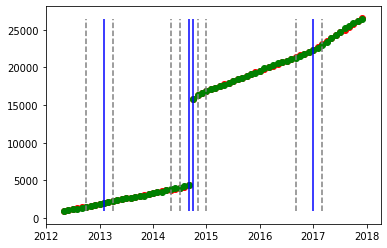

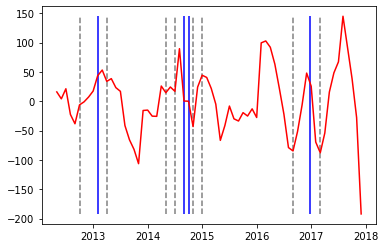

[2012.88940067 2014.07393031 2014.19255483 2015.08412836]


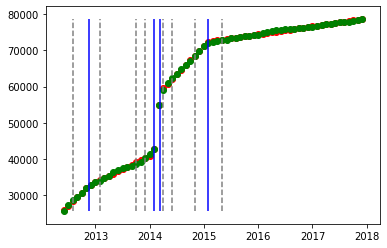

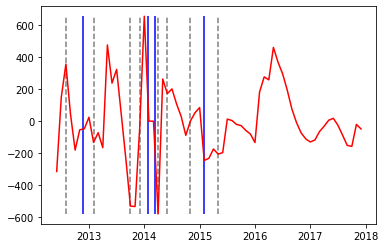

[2014.01555994 2015.17337165 2016.41666094 2016.50305145]


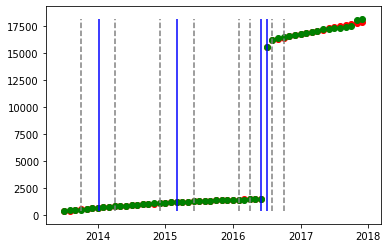

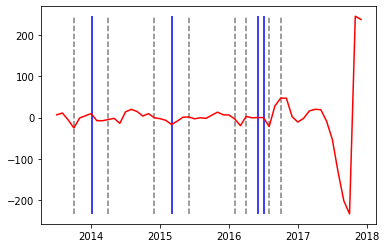

[2016.26357295 2016.88321764 2017.0029122  2017.56768139]


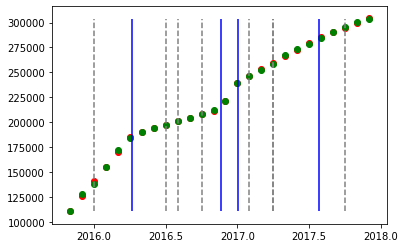

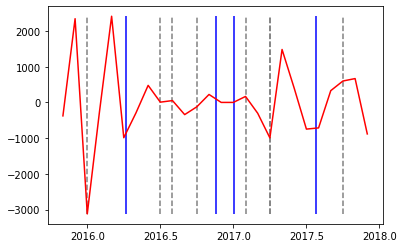

[2013.1666802  2014.06012193 2014.44654314 2016.33982148]


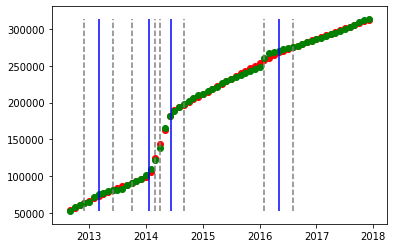

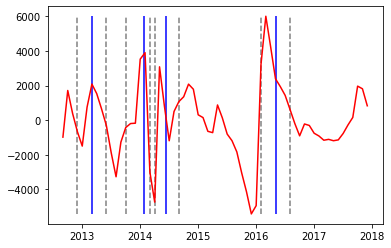

[2012.85167603 2014.9160722  2015.00181836 2016.66687168]


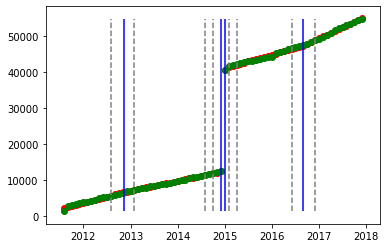

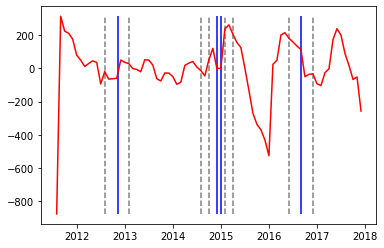

[2014.84298973 2015.55219997 2016.83273763 2016.94277487]


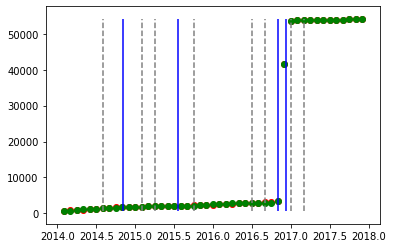

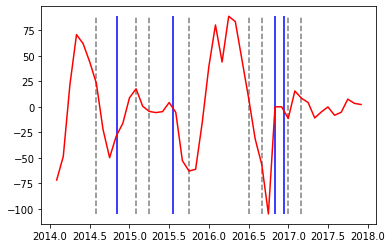

[2010.6949367  2013.62226952 2013.75366332 2015.0833332 ]


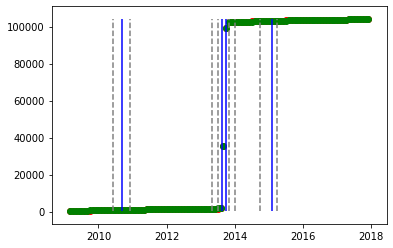

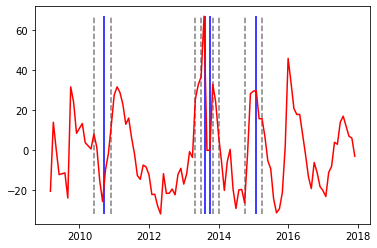

[2014.99386862 2015.08479488 2016.29234135 2017.11467636]


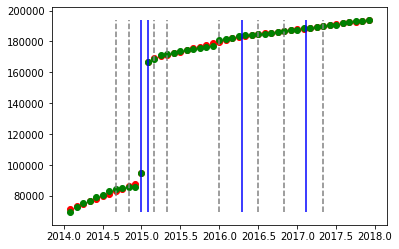

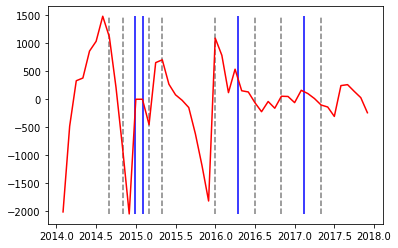

[ 16060    453  29297 155815  29088   4443 124440  33557   9466    348]
[2013.90921074 2014.27695251 2014.9590269 ]


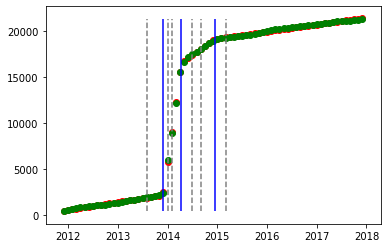

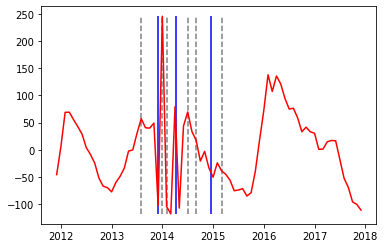

[2008.9997271  2013.1611918  2013.25044314]


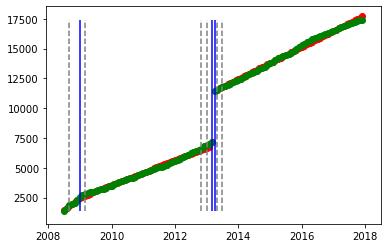

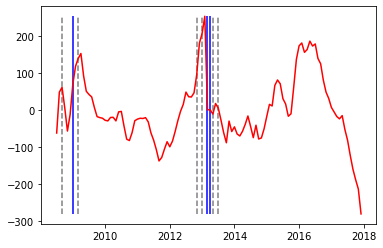

[2014.26915298 2016.01033509 2017.11774349]


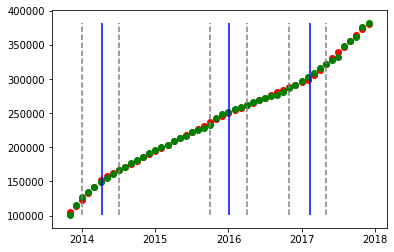

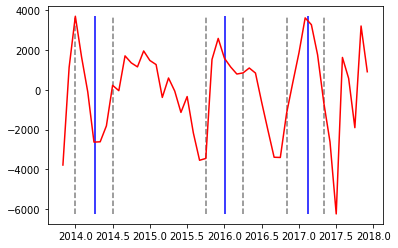

[2016.47641509 2016.74960465 2016.83592363]


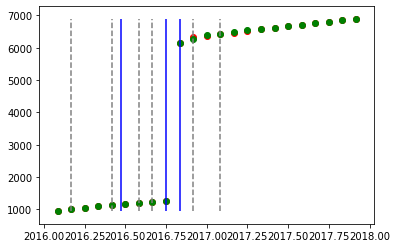

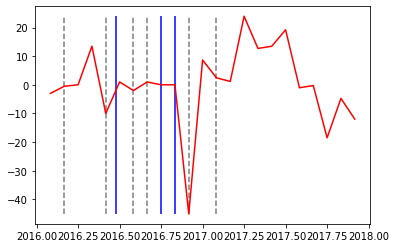

[2015.41396349 2016.79820526 2017.38922942]


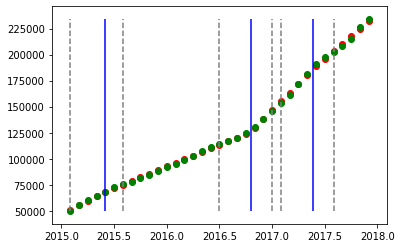

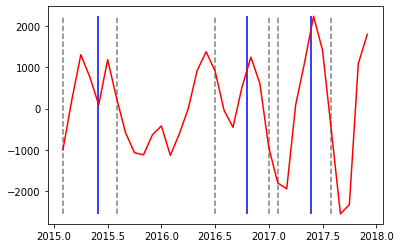

[2009.75077634 2015.54457312 2015.87020158]


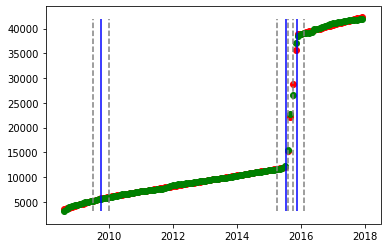

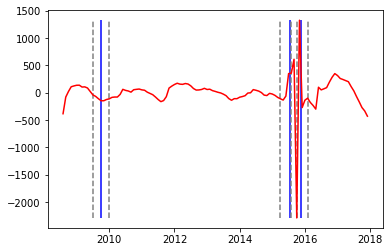

[2016.3847487  2016.99175514 2017.09475865]


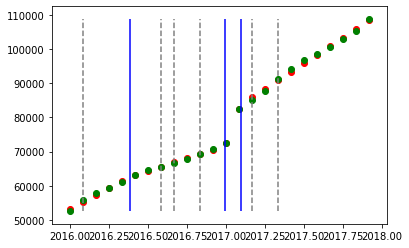

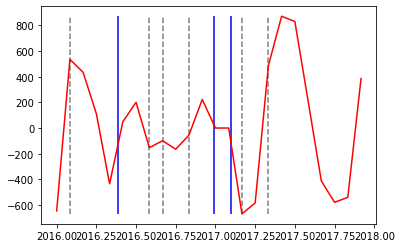

[2015.06068155 2015.40821537 2015.84104948]


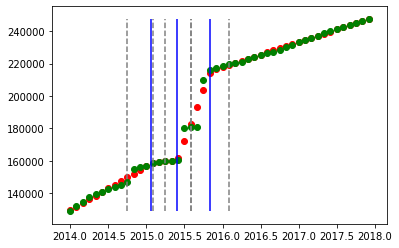

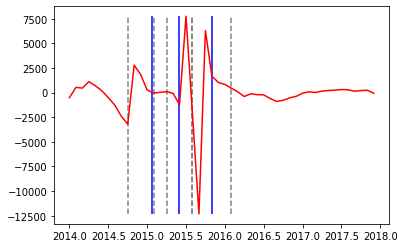

[2012.91592105 2013.00303671 2016.71224308]


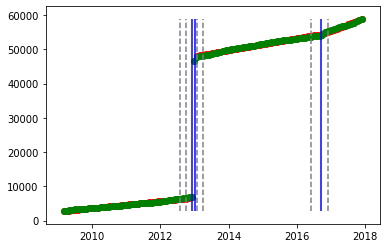

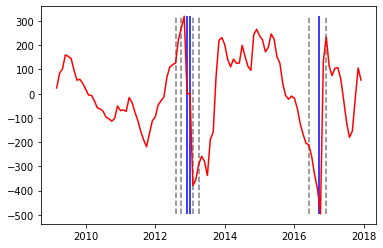

[2012.74543771 2012.8367026  2016.72923249]


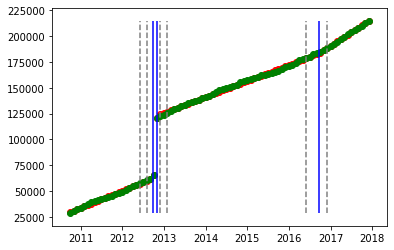

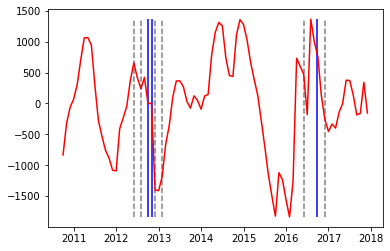

[  8305 137126 101688  72139 116877  78013  29063  32818  41716  66600]
[2013.79199661 2014.59203805]


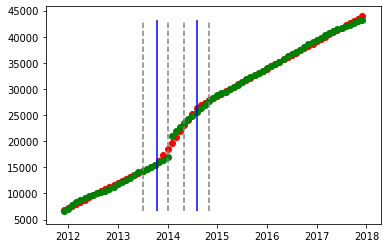

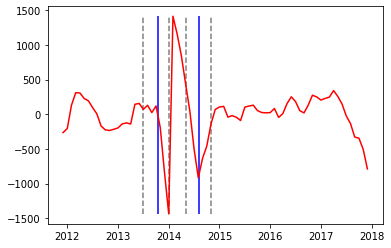

[2016.75965102 2017.72576693]


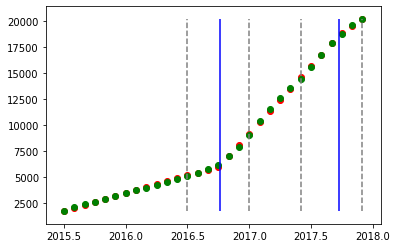

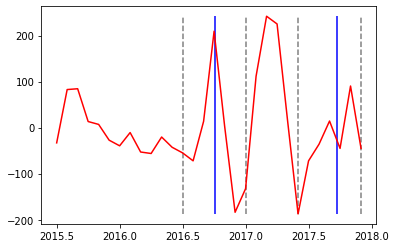

[2014.50947299 2017.12055176]


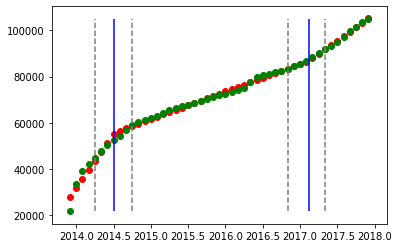

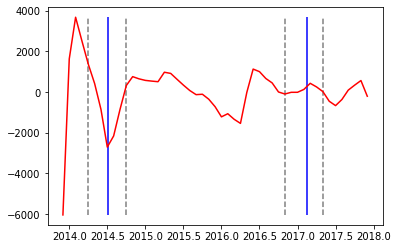

[2014.93329894 2016.93516322]


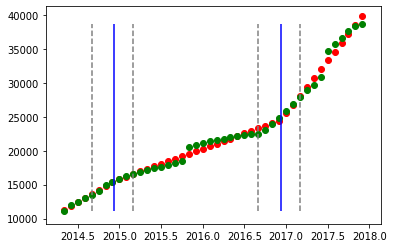

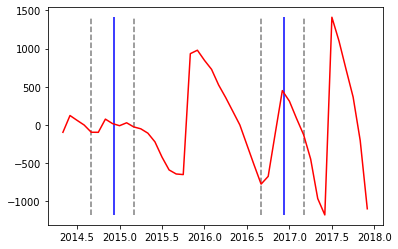

[2017.1734589  2017.40565079]


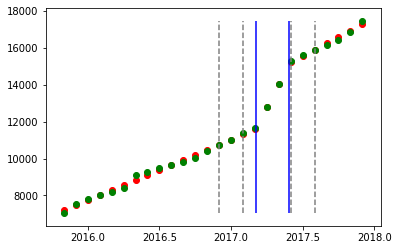

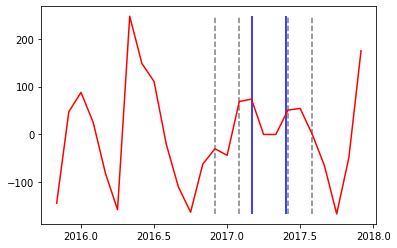

[2015.11682603 2015.8792866 ]


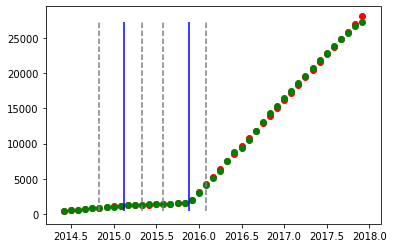

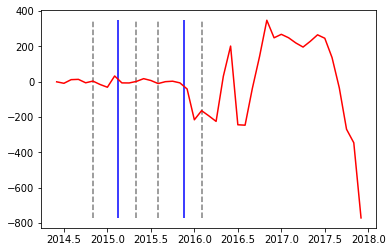

[2012.75029474 2016.26666419]


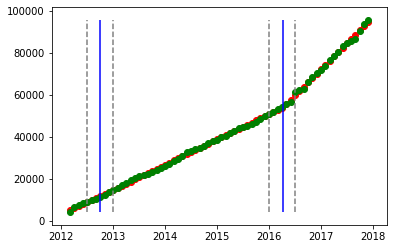

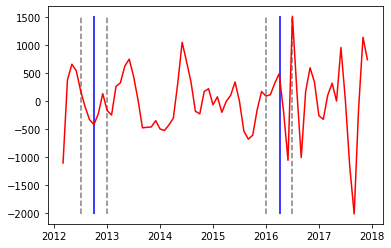

[2015.33019937 2016.84648367]


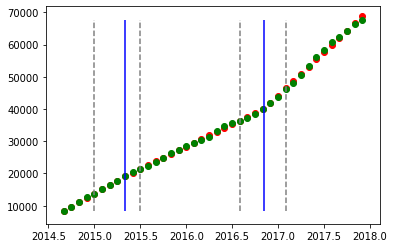

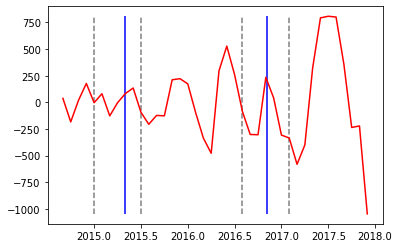

[2014.09066621 2016.68469729]


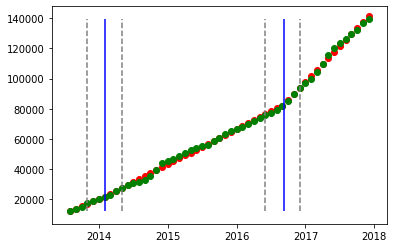

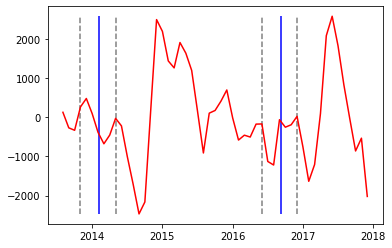

[2015.07685428 2016.80320993]


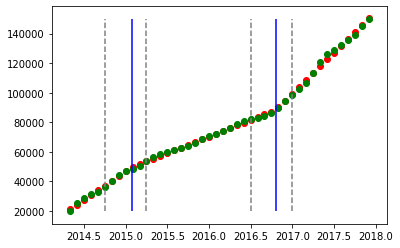

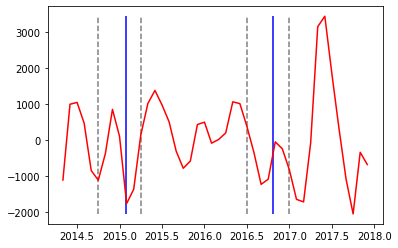

[153436  42396 118419 116101 152913 115498  29145  44978 123956 126030]
[2017.06183612]


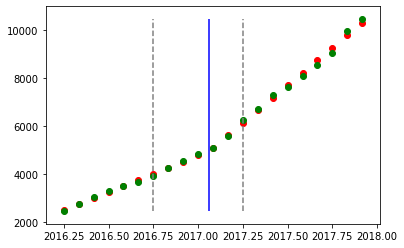

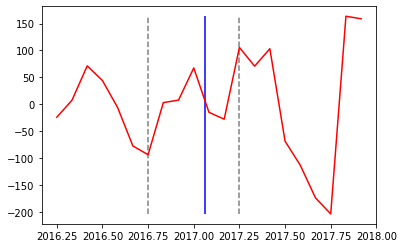

[2016.78787516]


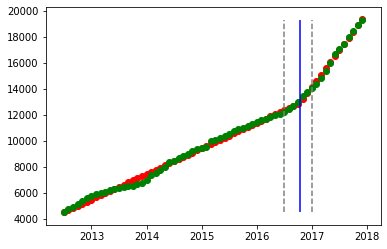

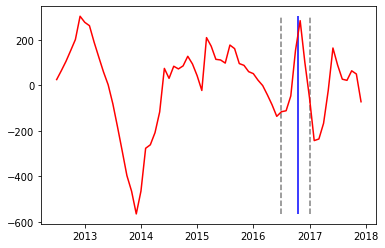

[2017.03331978]


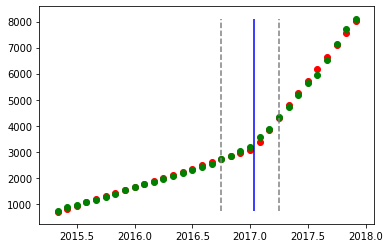

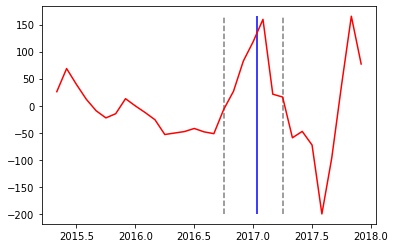

[2017.05641508]


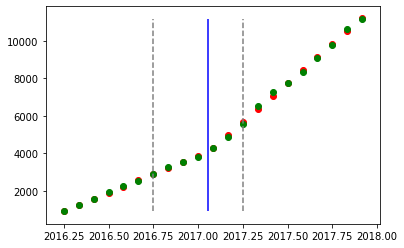

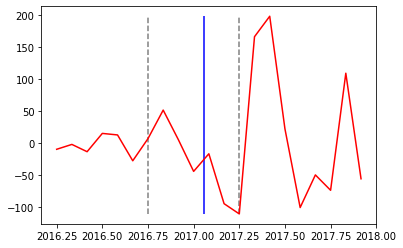

[2017.0292206]


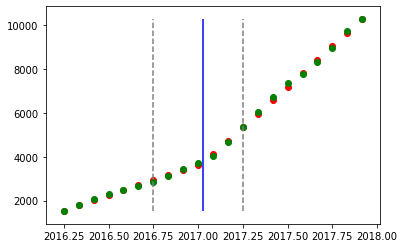

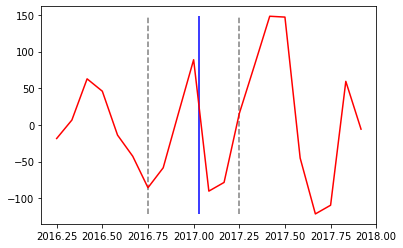

[2017.12429574]


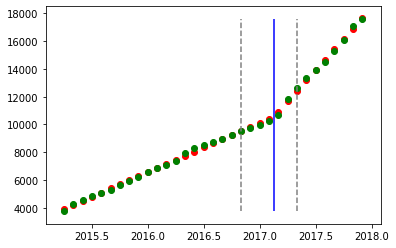

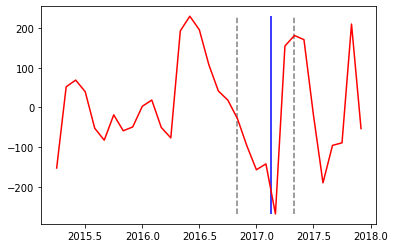

[2016.7283471]


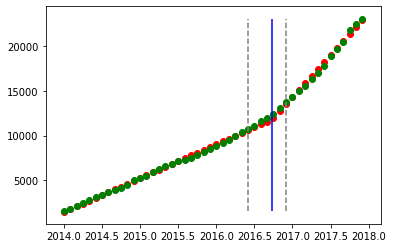

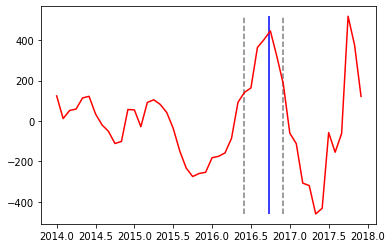

[2015.84911727]


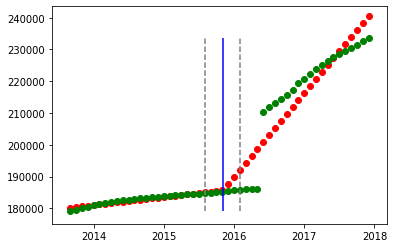

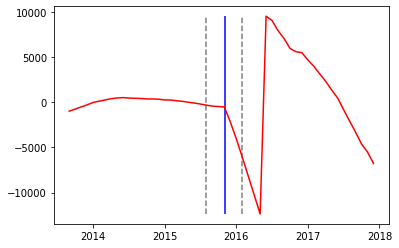

[2016.85941696]


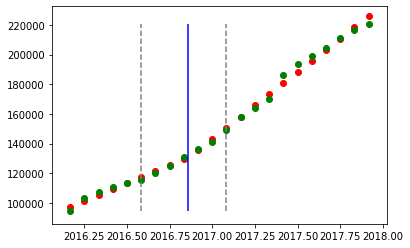

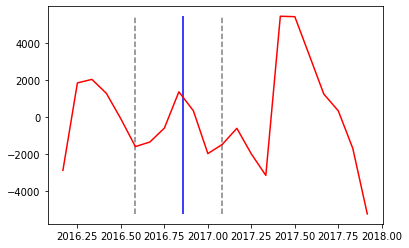

[2017.82942507]


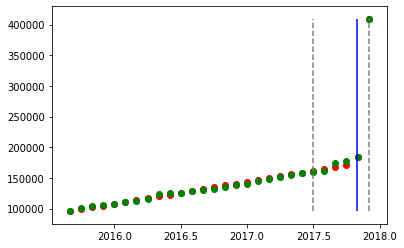

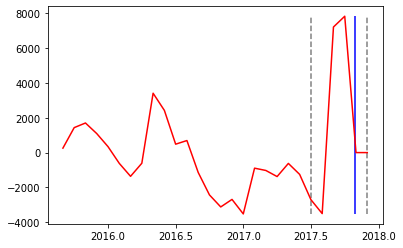

1
[ 66073 119930  75702  92885 108606 128339 124468  80570  24216 124028]
[2015.06008221 2016.17345285 2017.55390658]


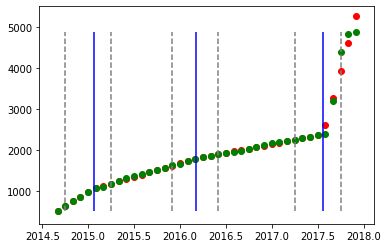

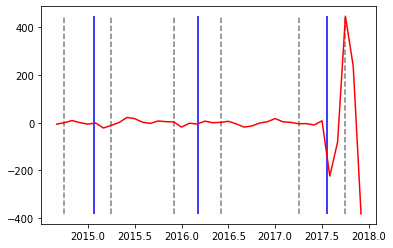

[2016.08188995 2016.17244346 2017.24809621]


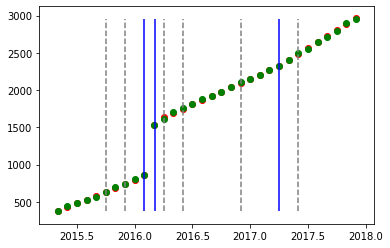

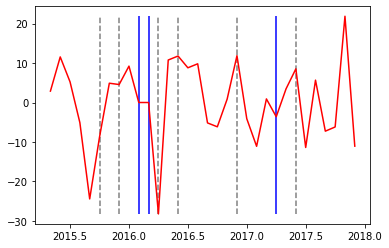

[2013.09100387 2014.73085754 2014.91696897]


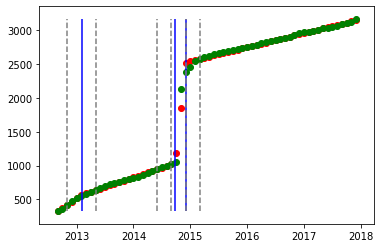

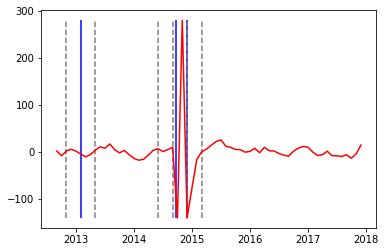

[2014.93918895 2016.49699651 2016.59630335]


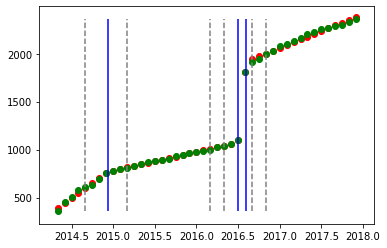

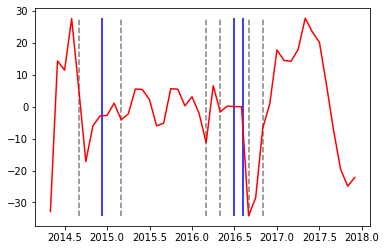

[2014.82959462 2015.10199381 2016.24999185]


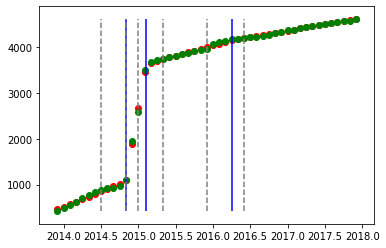

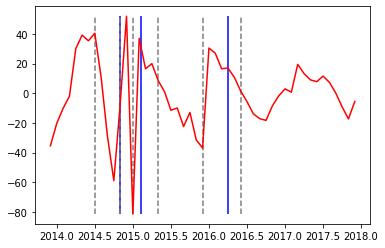

[2015.84759803 2017.23778695 2017.52543929]


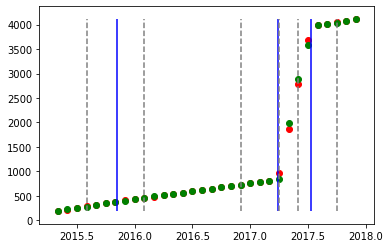

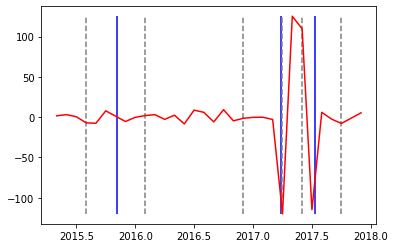

[2016.37834037 2016.83158628 2016.91667576]


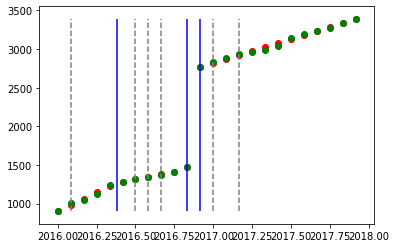

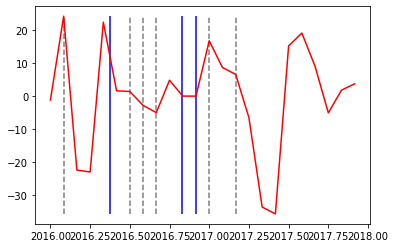

[2015.08334367 2016.83182584 2016.91735808]


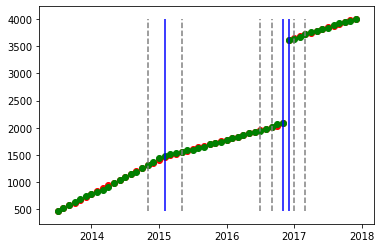

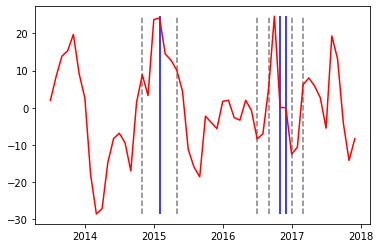

[2012.26819792 2014.16560661 2014.26464533]


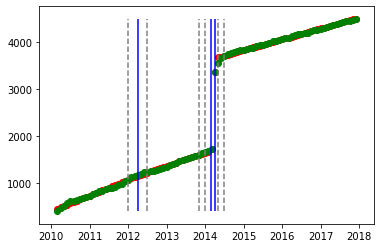

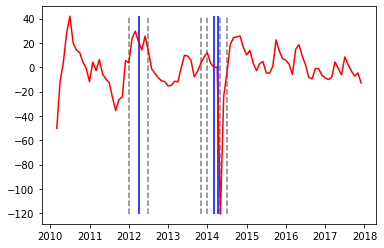

[2016.82895569 2016.917614   2017.75000365]


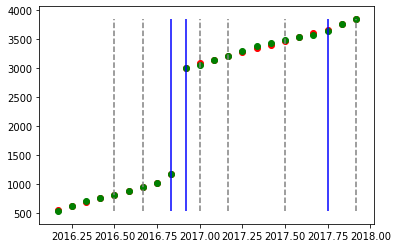

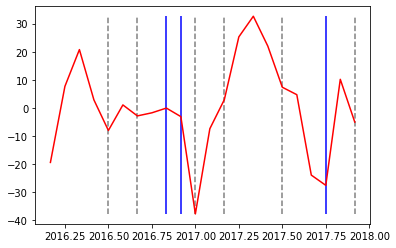

[126201 106531  14630  88585   6102  95781  43401  48860 104717  28967]
[2016.24876571 2016.34200239 2016.93688736 2017.33309311]


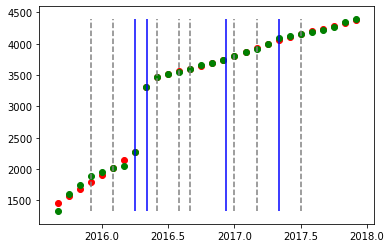

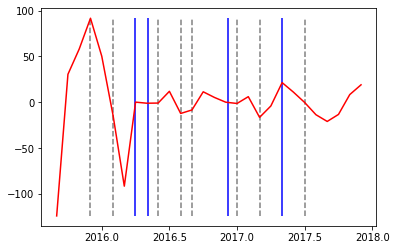

[2015.04293652 2015.91522305 2016.00028316 2017.54420387]


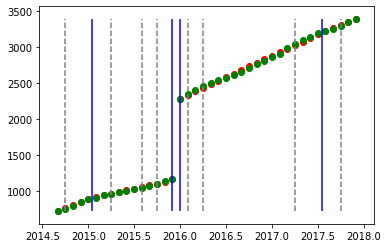

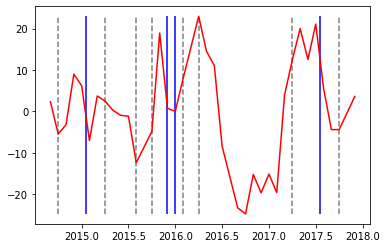

[2013.33015052 2013.4197486  2015.7077753  2016.09977857]


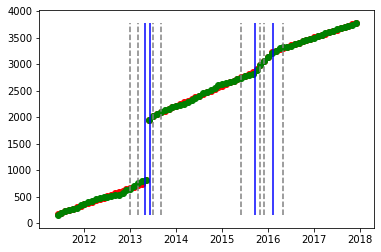

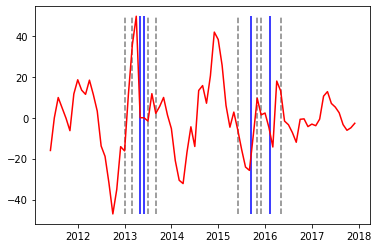

[2015.26053112 2015.83040389 2015.91880081 2016.60705325]


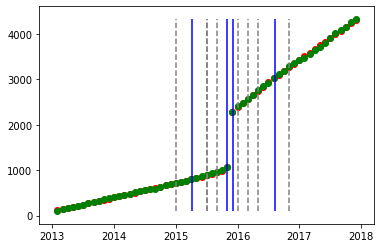

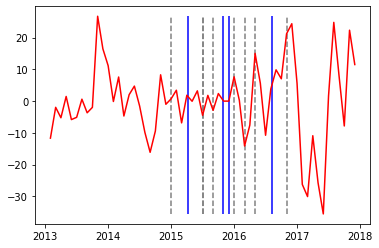

[2012.22757841 2013.16395907 2016.1629692  2016.25760884]


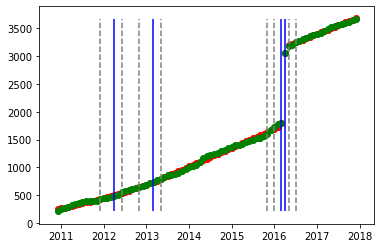

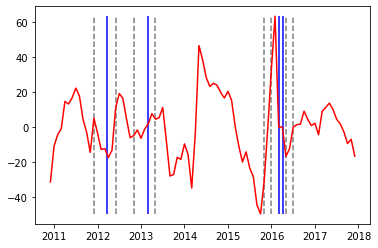

[2014.43914512 2015.00027084 2016.83326307 2016.91748175]


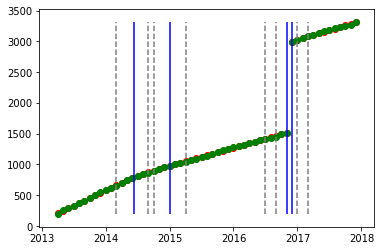

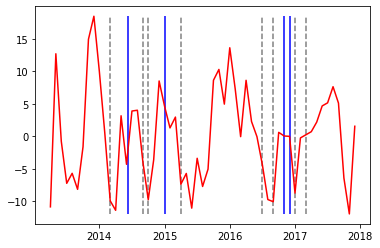

[2014.013017   2014.96359802 2016.8327973  2016.91679764]


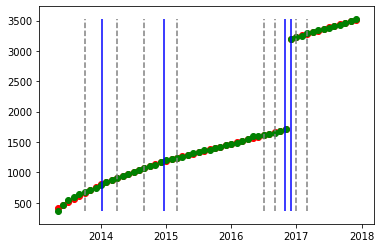

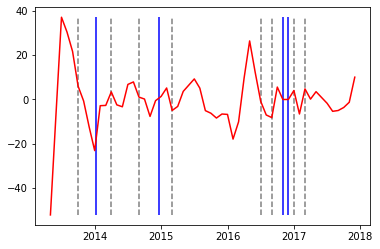

[2014.76777297 2016.08154141 2016.17149275 2017.38761996]


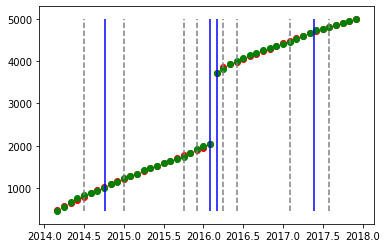

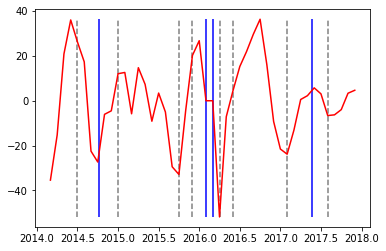

[2016.08068926 2016.4162717  2016.50014281 2017.02371236]


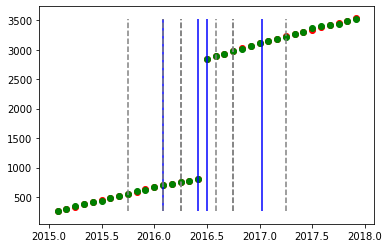

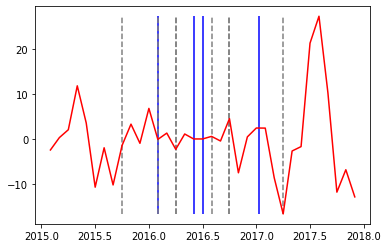

[2011.25096542 2013.48759003 2013.58356664 2015.64992461]


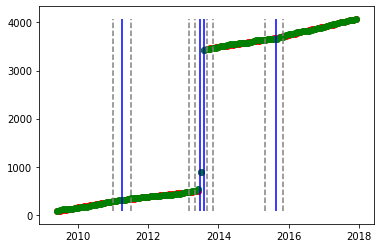

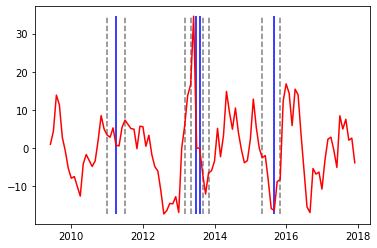

[162502  92201 154331 117358 152890 164410  63500  54671 124758 153263]
[2016.32657824 2016.42851605]


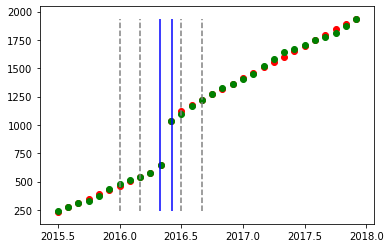

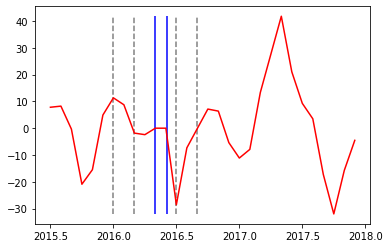

[2015.109887   2017.62127506]


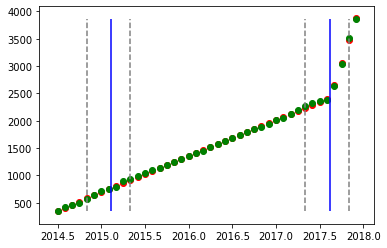

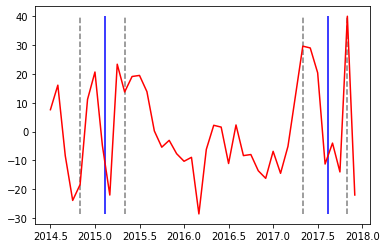

[2016.81822186 2016.96402205]


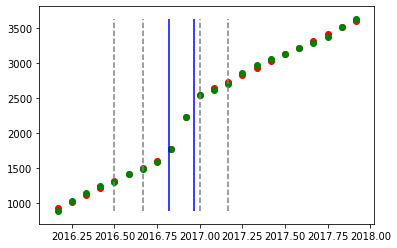

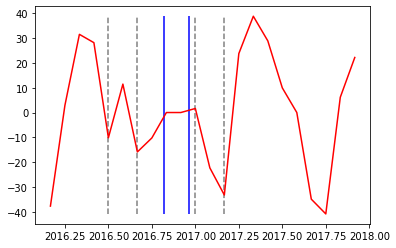

[2016.71910162 2017.12693148]


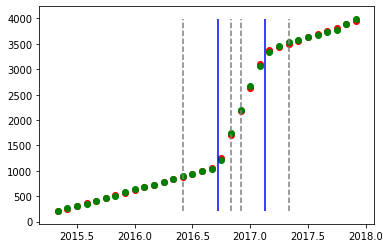

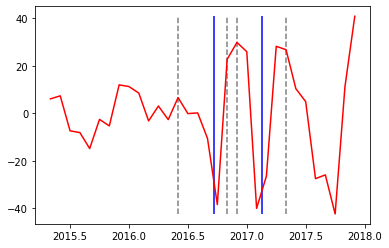

[2016.95573391 2017.08980678]


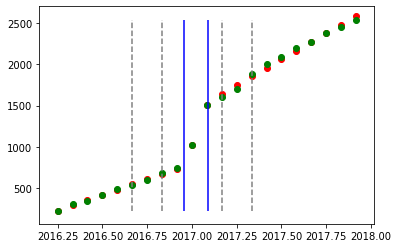

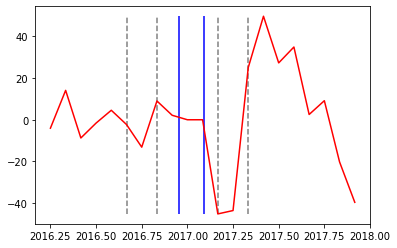

[2015.92921815 2016.08531409]


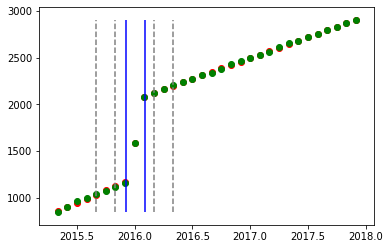

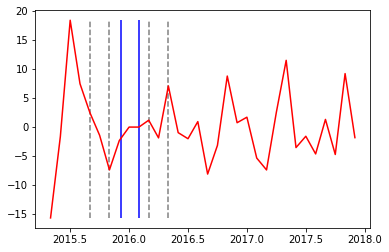

[2016.74364478 2017.00284977]


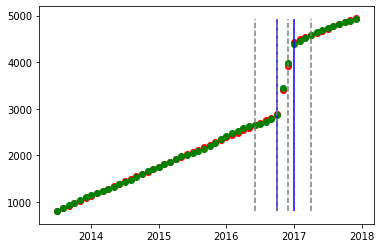

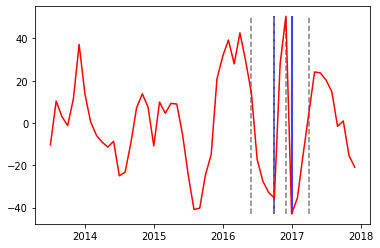

[2015.58221545 2015.68586611]


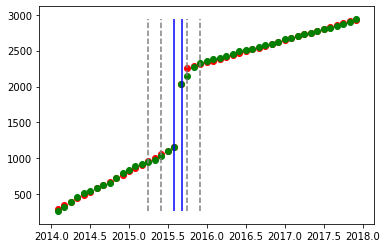

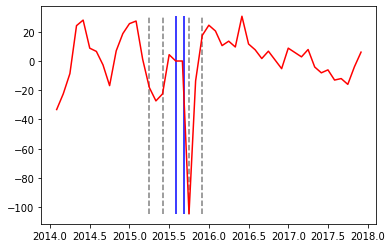

[2017.15398038 2017.25072429]


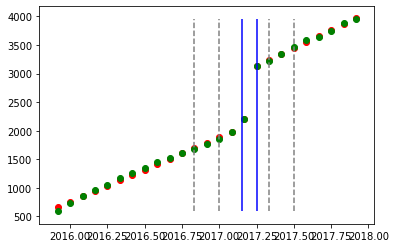

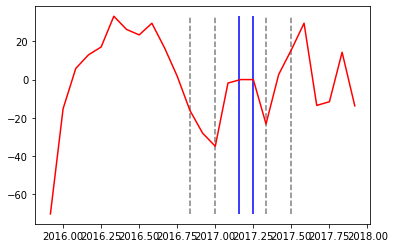

[2016.83300523 2016.91987799]


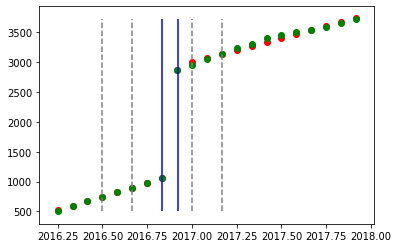

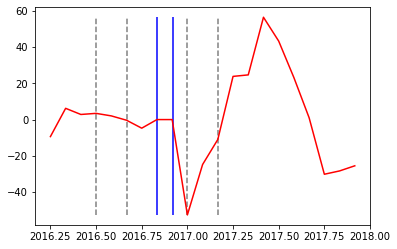

[130703 121137 122657 126831 124458 133366  94355  54161 160129 156628]
[2017.03954937]


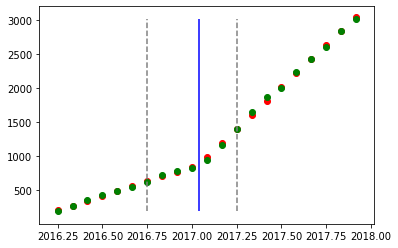

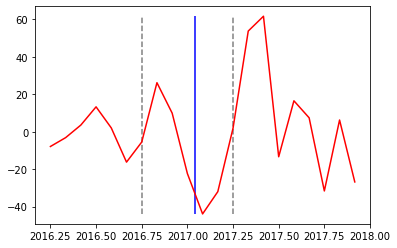

[2017.27510625]


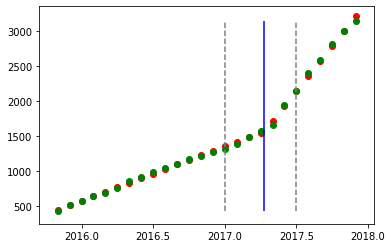

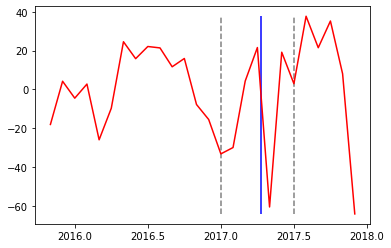

[2016.78612586]


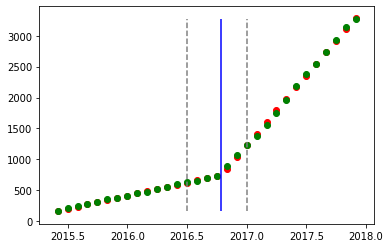

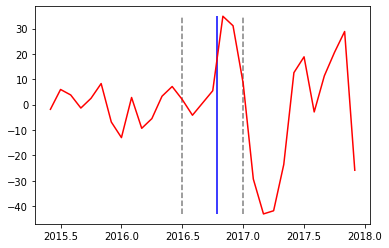

[2016.9729692]


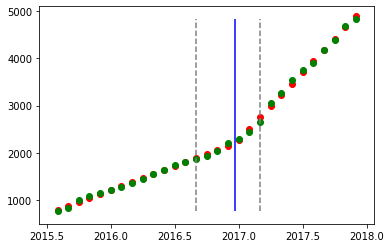

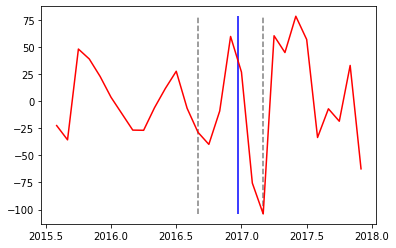

[2016.95572846]


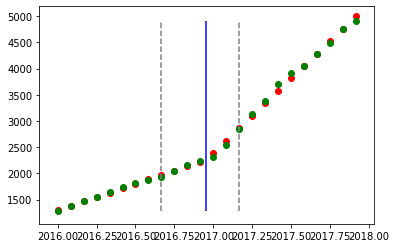

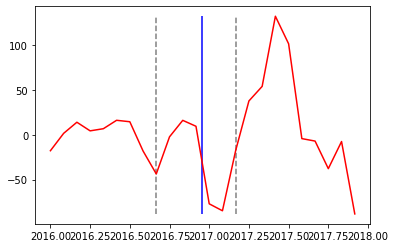

[2017.41333609]


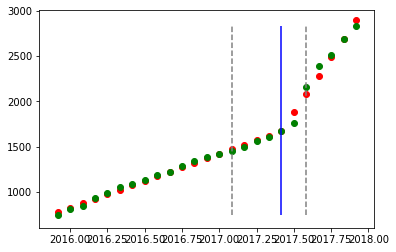

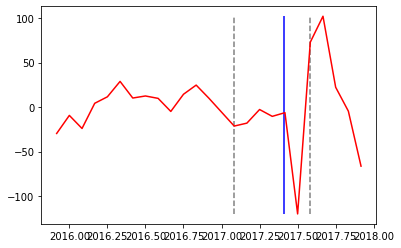

[2016.9549004]


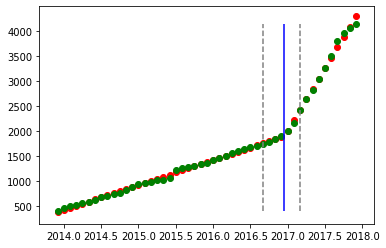

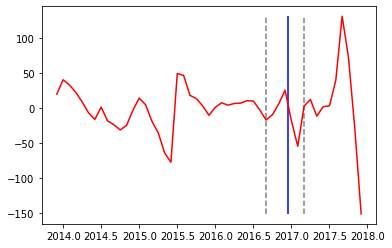

[2017.38618081]


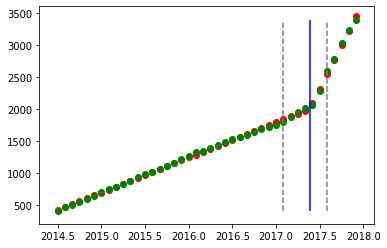

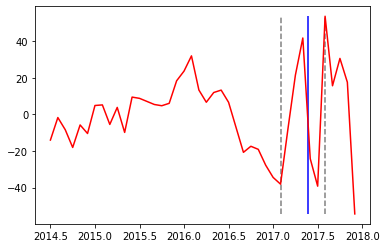

[2017.02818228]


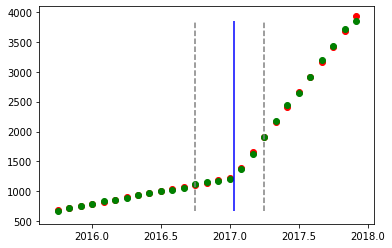

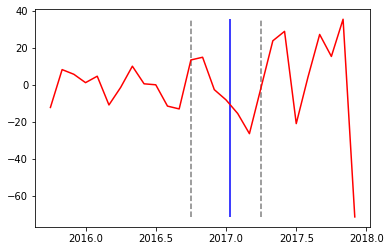

[2017.1927843]


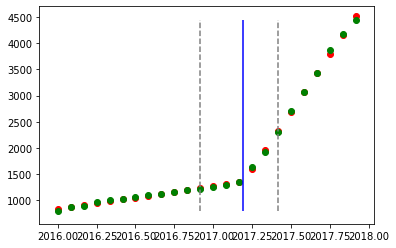

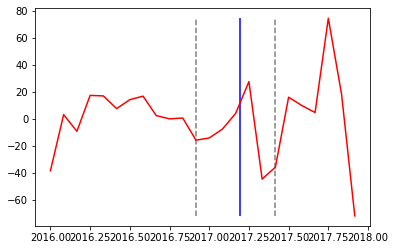

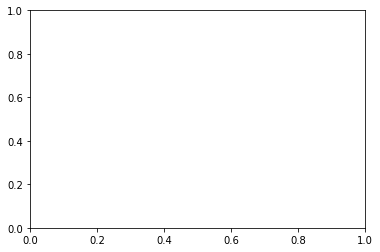

In [75]:
plot_series(groups)

In [15]:
def hist_delta_std(window_value,get_values):
    count = 0
    deltas_std = defaultdict(lambda:[]) 
    deltas_points = defaultdict(lambda:[])
    for k,idxs in groups.items():
        head = 'group'+str(k)
#         groupby_number_intervals = get_by_intervals(data,idxs)
#         for number_of_intervals,valid_idxs in groupby_number_intervals.items():
#             for idx in valid_idxs:
        for idx in idxs:
            sample = data[idx]
            x = norm(sample[2])
            y = norm(sample[3])
            y_pred = sample[-1]
            bpoints = sample[1]
            slopes = sample[0]

            for i,b in enumerate(bpoints):
                vs = get_values(x,y,b,window_value)
                std = np.std(vs)
                slope_diff = slopes[i+1]-slopes[i]
                count += 1
                key = 1 if slope_diff > 0 else -1
                deltas_std[key].append(std)
                deltas_points[key].append(vs)
#     print(count)
    return deltas_std,deltas_points

In [16]:
def hists(delta,get_values):
    deltas_std,deltas_points = hist_delta_std(delta,get_values)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3),sharey=True)
    curve_pos_std = np.nanmean(deltas_std[1])
    ax1.hist(deltas_std[1], 10, density=True, facecolor='g', alpha=0.75, range=(0,0.1))
    ax1.set_title('Curve (positive) std mean = %.4f '% curve_pos_std)
    
    curve_neg_std = np.nanmean(deltas_std[-1])
    ax2.hist(deltas_std[-1], 10, density=True, facecolor='g', alpha=0.75,range=(0,0.1))
    ax2.set_title('Curve (negative) std mean = %.4f '% curve_neg_std)
    fig.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3),sharey=True)
    ys1 = np.nanmean(deltas_points[1],axis=0)
    std1 = np.nanstd(deltas_points[1],axis=0)
    print(std1)
#     print('ys1',ys1)
#     print('min',np.nanmin(deltas_points[1],axis=0),'max',np.nanmax(deltas_points[1],axis=0))
    xs = list(range(len(ys1)))
    ax1.errorbar(xs,ys1,yerr=std1)
    ax1.scatter(xs,ys1)
    ax1.set_title('Curve (positive)')
    
    ys2 = np.nanmean(deltas_points[-1],axis=0)
    std2 = np.nanstd(deltas_points[-1],axis=0)
    print(std2)
#     print(deltas_points[-1][:10])
#     print(deltas_points[-1][-10:])
#     print('ys2',ys2)
#     print('min',np.nanmin(deltas_points[-1],axis=0),'max',np.nanmax(deltas_points[-1],axis=0))
    xs = list(range(len(ys2)))
    ax2.errorbar(xs,ys2,yerr=std2)
    ax2.scatter(xs,ys2)
    ax2.set_title('Curve (negative)')
    fig.show()

In [ ]:
hists(0.01,get_values_window) # não funciona

In [ ]:
hists(0.02,get_values_window)

In [ ]:
hists(0.03,get_values_window)

/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


[0.21121511 0.20919095]
[0.26226918 0.24912609]


/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


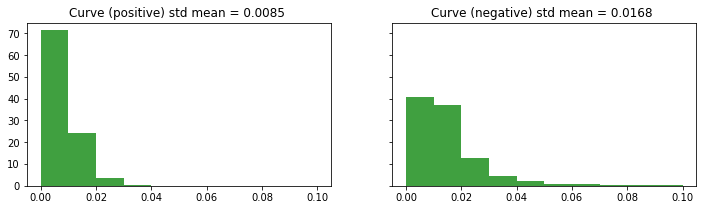

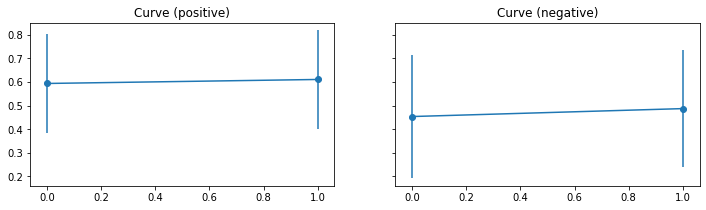

In [18]:
hists(1,get_values_points)

/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


[0.21343331 0.21121511 0.20919095 0.20709289]
[0.26847651 0.26226918 0.24912609 0.24347135]


/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


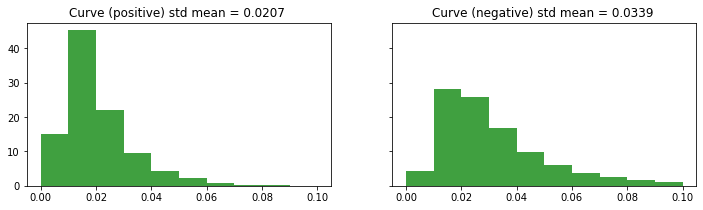

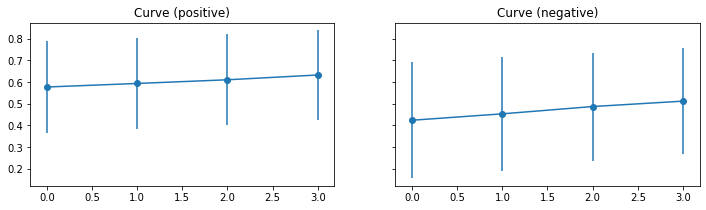

In [19]:
hists(2,get_values_points)

/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


[0.2160591  0.21343331 0.21121511 0.20919095 0.20709289 0.22721479]
[0.27123226 0.26847651 0.26226918 0.24912609 0.24347135 0.24031284]


/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


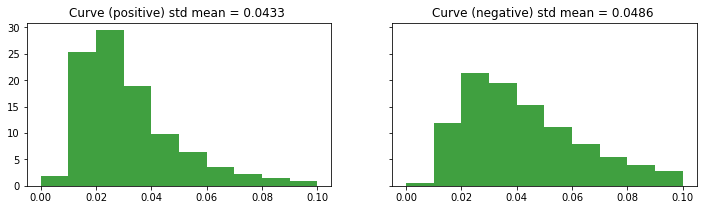

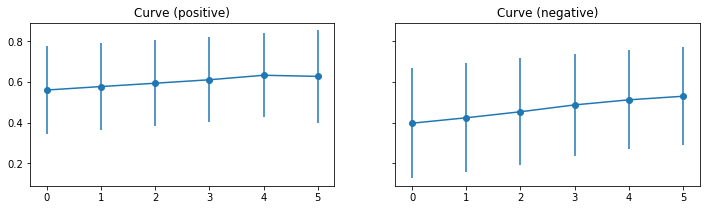

In [20]:
hists(3,get_values_points)

In [ ]:
# janela de pontos vs a curva (se está captando a diferença)

In [18]:
#errorbar ok
#sem normalizar (refazer)
#agrupar usando medida do paper

In [ ]:
# histograma do tempo de cada artigo
# histograma da quantidade de quebras
# filtrar os artigos com 4 ou menos anos de vida
# histograma de visualização de artigos